In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CIC-PDFMal2022\\PDFMalware2022.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10026 entries, 0 to 10025
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fine name         10026 non-null  object 
 1   pdfsize           10025 non-null  float64
 2   metadata size     10025 non-null  float64
 3   pages             10025 non-null  float64
 4   xref Length       10025 non-null  float64
 5   title characters  10025 non-null  float64
 6   isEncrypted       10025 non-null  float64
 7   embedded files    10025 non-null  float64
 8   images            10025 non-null  object 
 9   text              10025 non-null  object 
 10  header            10025 non-null  object 
 11  obj               10023 non-null  object 
 12  endobj            10023 non-null  object 
 13  stream            10023 non-null  float64
 14  endstream         10023 non-null  object 
 15  xref              10023 non-null  object 
 16  trailer           10023 non-null  float6

In [4]:
#Feature Selection
features = DM.drop(['Fine name','images','text','header','obj','endobj','endstream','xref','startxref','pageno','JS','Javascript','AA','OpenAction','Acroform','JBIG2Decode','RichMedia','launch','EmbeddedFile','XFA','Class'],axis=1).columns.tolist()
# Target variable
y = DM['Class'].values

In [5]:
# Memilih 5% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('Class').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

In [6]:
for i, column_name in enumerate(features):
    print(f"{i+1:3} {column_name:40} {sampled_data[column_name].count():<15} {sampled_data[column_name].dtype}")

  1 pdfsize                                  10025           float64
  2 metadata size                            10025           float64
  3 pages                                    10025           float64
  4 xref Length                              10025           float64
  5 title characters                         10025           float64
  6 isEncrypted                              10025           float64
  7 embedded files                           10025           float64
  8 stream                                   10023           float64
  9 trailer                                  10023           float64
 10 encrypt                                  10023           float64
 11 ObjStm                                   10023           float64
 12 Colors                                   10023           float64


In [7]:
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

hasil_threshold = []

def Thresholding(threshold, feature):
    start_time = time.time()  # Mulai penghitungan waktu

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Class"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malicious"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Class"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    # Menghitung waktu running
    run_time = time.time() - start_time

    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold], [run_time]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)


Progress: 100%|████████████████████████████████████████████████████████████████████| 12/12 [3:48:58<00:00, 1144.88s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = [['', 0], [0], [0], [0], [0], [0]]
winner_recall = [['', 0], [0], [0], [0], [0], [0]]
winner_f1_score = [['', 0], [0], [0], [0], [0], [0]]
winner_accuracy = [['', 0], [0], [0], [0], [0], [0]]
winner_run_time = [['', 0], [0], [0], [0], [0], [float('inf')]]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

for result in hasil_threshold:
    # Membandingkan Precision
    if result[1][0] > winner_precision[1][0]:
        winner_precision = result
    
    # Membandingkan Recall
    if result[2][0] > winner_recall[2][0]:
        winner_recall = result

    # Membandingkan F1-score
    if result[3][0] > winner_f1_score[3][0]:
        winner_f1_score = result

    # Membandingkan Accuracy
    if result[4][0] > winner_accuracy[4][0]:
        winner_accuracy = result

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result[5][0] < winner_run_time[5][0]:
        winner_run_time = result

In [9]:
# Fungsi untuk memfilter dan plot berdasarkan pemenang
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
    for result in winner_results:
        thresholds.append(result[0][1])
        precision.append(result[1][0])
        recall.append(result[2][0])
        f1_score.append(result[3][0])
        accuracy.append(result[4][0])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy')
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label='Recall')
    plt.plot(thresholds, f1_score, label='F1 Score')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

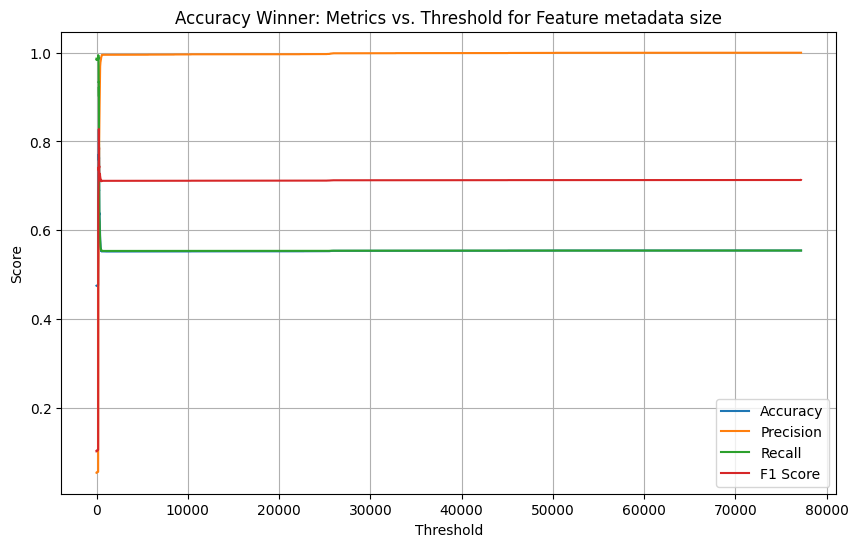

In [10]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

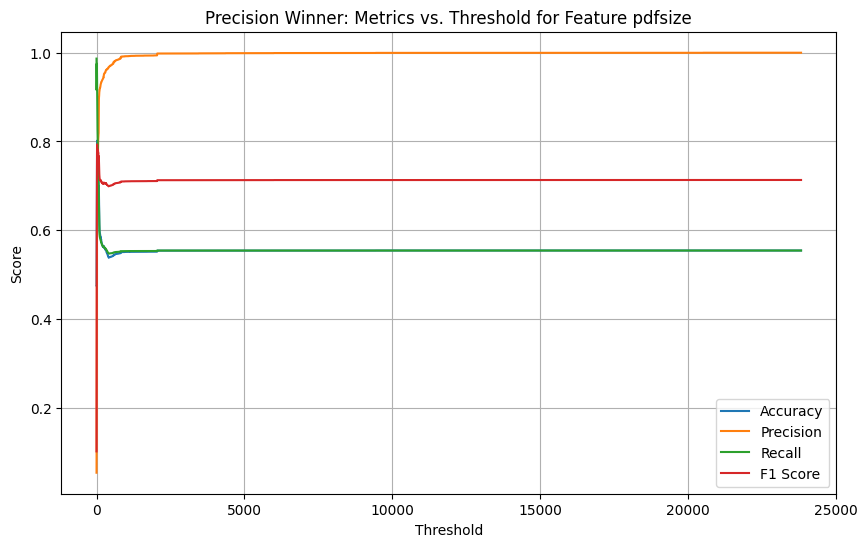

In [11]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

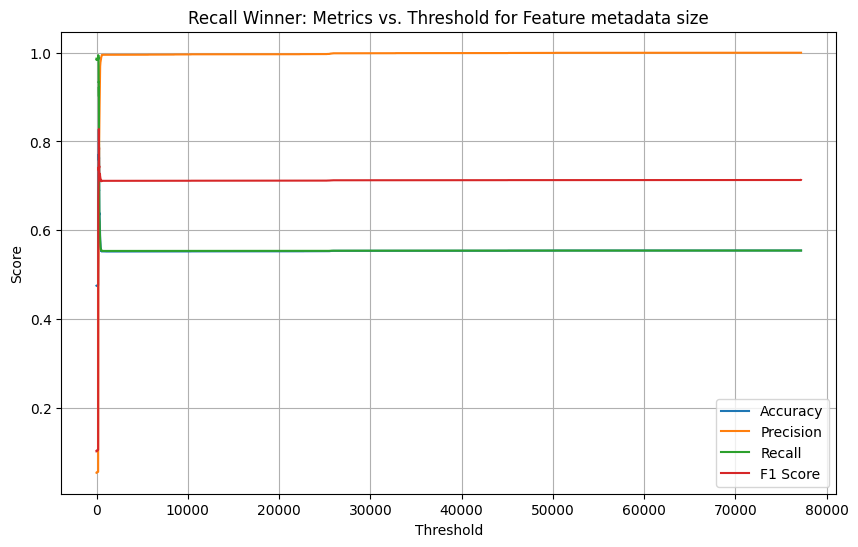

In [12]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

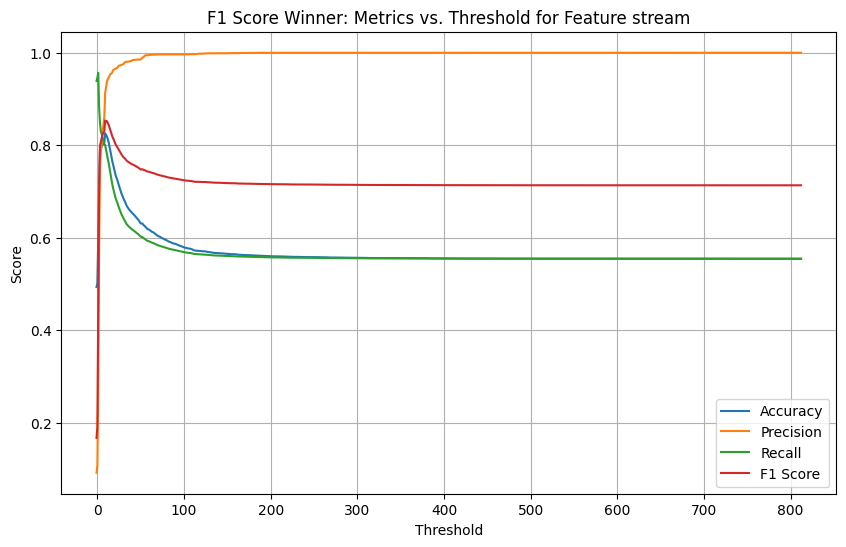

In [13]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

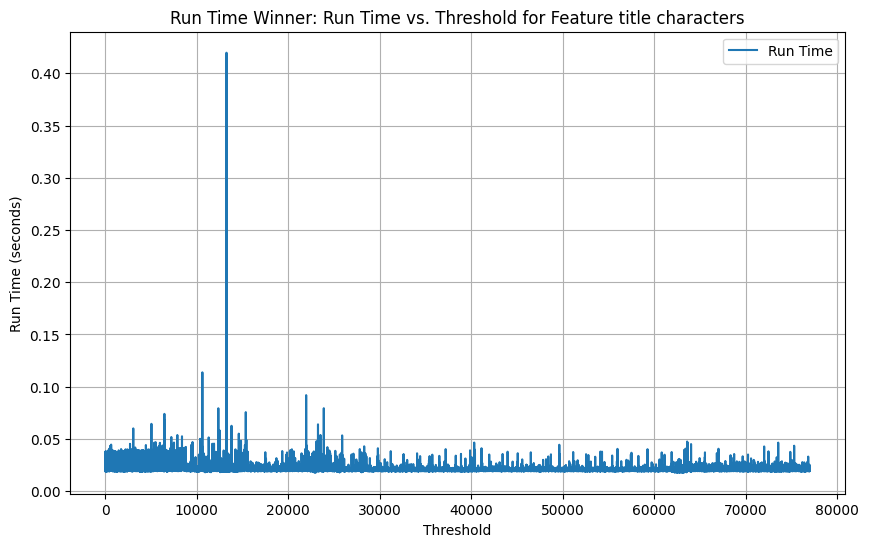

In [14]:
# Plot untuk run time winner
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds, run_time = [], []
    for result in winner_results:
        thresholds.append(result[0][1])
        run_time.append(result[5][0])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)


In [15]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0][0]} dan threshold {winner_precision[0][1]}, menghasilkan precision {winner_precision[1][0]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0][0]} dan threshold {winner_recall[0][1]}, menghasilkan recall {winner_recall[2][0]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0][0]} dan threshold {winner_f1_score[0][1]}, menghasilkan F1-score {winner_f1_score[3][0]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0][0]} dan threshold {winner_accuracy[0][1]}, menghasilkan akurasi {winner_accuracy[4][0]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0][0]} dan threshold {winner_run_time[0][1]}, dengan waktu running {winner_run_time[5][0]} detik.")

Precision terbaik dicapai dengan fitur pdfsize dan threshold 20510, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur metadata size dan threshold 189, menghasilkan recall 0.994314143567875.
F1-score terbaik dicapai dengan fitur stream dan threshold 9, menghasilkan F1-score 0.8530821629804054.
Akurasi terbaik dicapai dengan fitur metadata size dan threshold 259, menghasilkan akurasi 0.8270324189526185.
Waktu running tercepat dicapai dengan fitur title characters dan threshold 63221, dengan waktu running 0.01761150360107422 detik.
